# Healthcare analytics

### Roger Montané Güell (1569031)

Kaggle dataset: https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii

In [99]:
import os

import numpy as np

import collections

import time

from random import randint

from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.pyplot import figure
from matplotlib import cm
from colorspacious import cspace_converter
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd

import scipy.stats

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc


# Models used in classification:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Over/under sampling techniques:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb

from lazypredict.Supervised import LazyClassifier

from tabulate import tabulate

# PyTorch
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tqdm

Let's load the data:

In [2]:
# Function to read csv files and save them as a pandas structure
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

In [3]:
train = load_dataset('../data/train_data.csv')
train_data = train.copy(deep=True)
train_data.shape

(318438, 18)

In [4]:
test = load_dataset('../data/test_data.csv')
test_data = test.copy(deep=True)
test_data.shape

(137057, 17)

---

### Exploratory Data Analysis (on the train dataset)
Train data info:

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

Let's see the columns of the dataset:

In [6]:
train_data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50


We also check for NaN values:

In [7]:
train_data.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

We can either fill this Nan values with a statistical method (mean, mode, etc.), or just get rid of every row that has a Nan value:

In [8]:
# For now let's just drop them
train_data = train_data.dropna()
train_data.isna().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

In [9]:
test_data = test_data.dropna()
test_data.isna().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
dtype: int64

In [10]:
train_data.shape

(313793, 18)

In [11]:
test_data.shape

(134865, 17)

---

#### Feature selection
We have to consider the following:
* `case_id`, `patientid`, `Hospital_code` are not relevant, they are just id's
* `Visitors with Patient` is something we can not know beforehand (it may cause overfitting by correlating directly with `Stay`
* `City_hospital_code` is also not used since we can use `Hospital_region_code` instead
* `City_code_patient` does not seem relevant, the city a patient is from should not affect the LOS
* `Hospital_type_code`, `Hospital_region_code`, `Department`, `Ward_Type` and `Ward_Facility_Code` will be One hot encoded

In [12]:
train_data.drop(['case_id', 'patientid', 'Hospital_code', 'City_Code_Hospital', 'City_Code_Patient', 'Visitors with Patient']
               , axis = 1, inplace = True)
test_data.drop(['case_id', 'patientid', 'Hospital_code', 'City_Code_Hospital', 'City_Code_Patient', 'Visitors with Patient']
               , axis = 1, inplace = True)
train_data.head()

,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,Type of Admission,Severity of Illness,Age,Admission_Deposit,Stay
0,c,Z,3,radiotherapy,R,F,2.00,Emergency,Extreme,51-60,4911.00,0-10
1,c,Z,2,radiotherapy,S,F,2.00,Trauma,Extreme,51-60,5954.00,41-50
2,e,X,2,anesthesia,S,E,2.00,Trauma,Extreme,51-60,4745.00,31-40
3,b,Y,2,radiotherapy,R,D,2.00,Trauma,Extreme,51-60,7272.00,41-50
4,b,Y,2,radiotherapy,S,D,2.00,Trauma,Extreme,51-60,5558.00,41-50


---

#### Numerical and categorical data

In [13]:
cat_cols=[]
num_cols=[]

for col in train_data.columns:
    if train_data[col].dtypes == 'object':
        cat_cols.append(col)
        
for col in train_data.columns:
    if train_data[col].dtypes != 'object':
        num_cols.append(col)
        
print("Categorical columns:")
print(cat_cols)

Categorical columns:
['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']


In [14]:
print("Numerical columns:")
print(num_cols)

Numerical columns:
['Available Extra Rooms in Hospital', 'Bed Grade', 'Admission_Deposit']


---

#### Analyising numerical variables

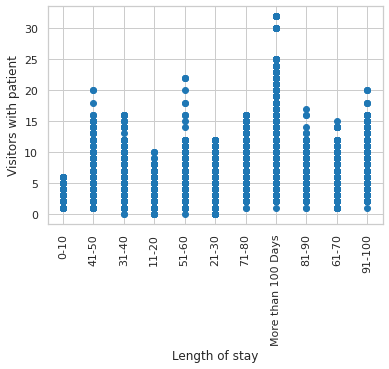

In [15]:
plt.xticks(rotation=90)
plt.xlabel('Length of stay')
plt.ylabel('Visitors with patient')
plt.scatter(train['Stay'], train['Visitors with Patient'])
plt.show()

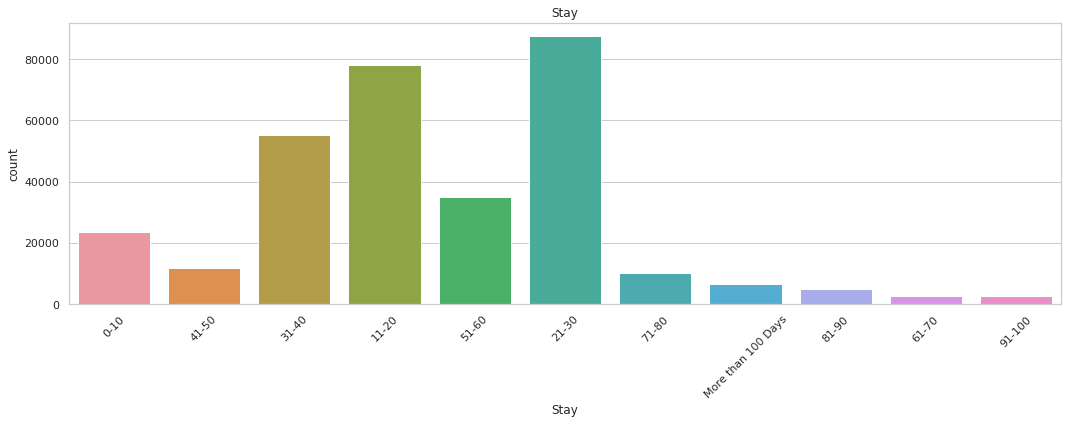

In [16]:
figure(figsize=(15,5))
sns.countplot('Stay',data=train)
plt.title('Stay')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

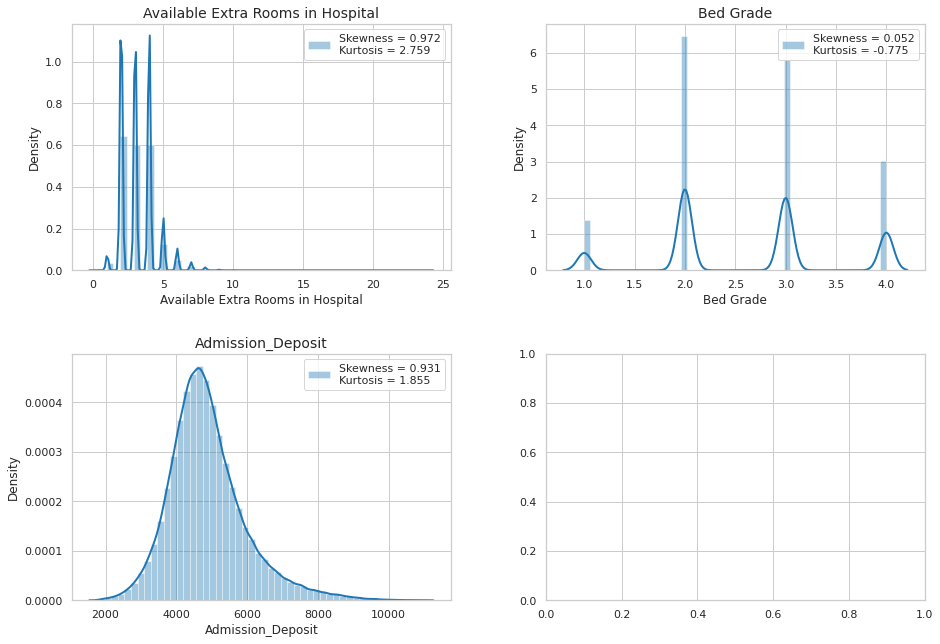

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))
fig.tight_layout(pad=5.0)

for ax, category in zip(ax.flatten(), num_cols):
    skew = train[category].skew()
    kurt = train[category].kurt()
    lab = "Skewness = {:.3f}\nKurtosis = {:.3f}".format(skew, kurt)
    sns.distplot(ax=ax, a=train[category].dropna(), label=lab)
    ax.set_title(category, fontsize = 14)
    ax.legend(loc = 'best')

In [18]:
# TODO: explicar skewness

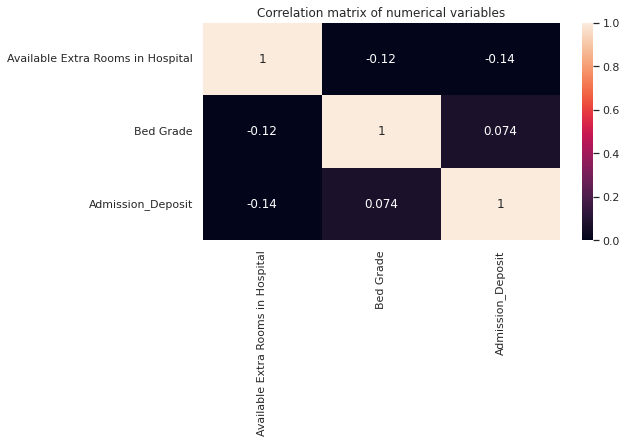

In [19]:
heatmapdata = train[num_cols]
cormat = heatmapdata.corr()
fig, ax = plt.subplots(figsize = (8,4))
sns.heatmap(data = cormat, vmin=0, vmax=1, annot=True)
plt.title("Correlation matrix of numerical variables")
plt.show()

In [20]:
# TODO: explicar correlacions, mes analisis?

#### Analysing categorical variables

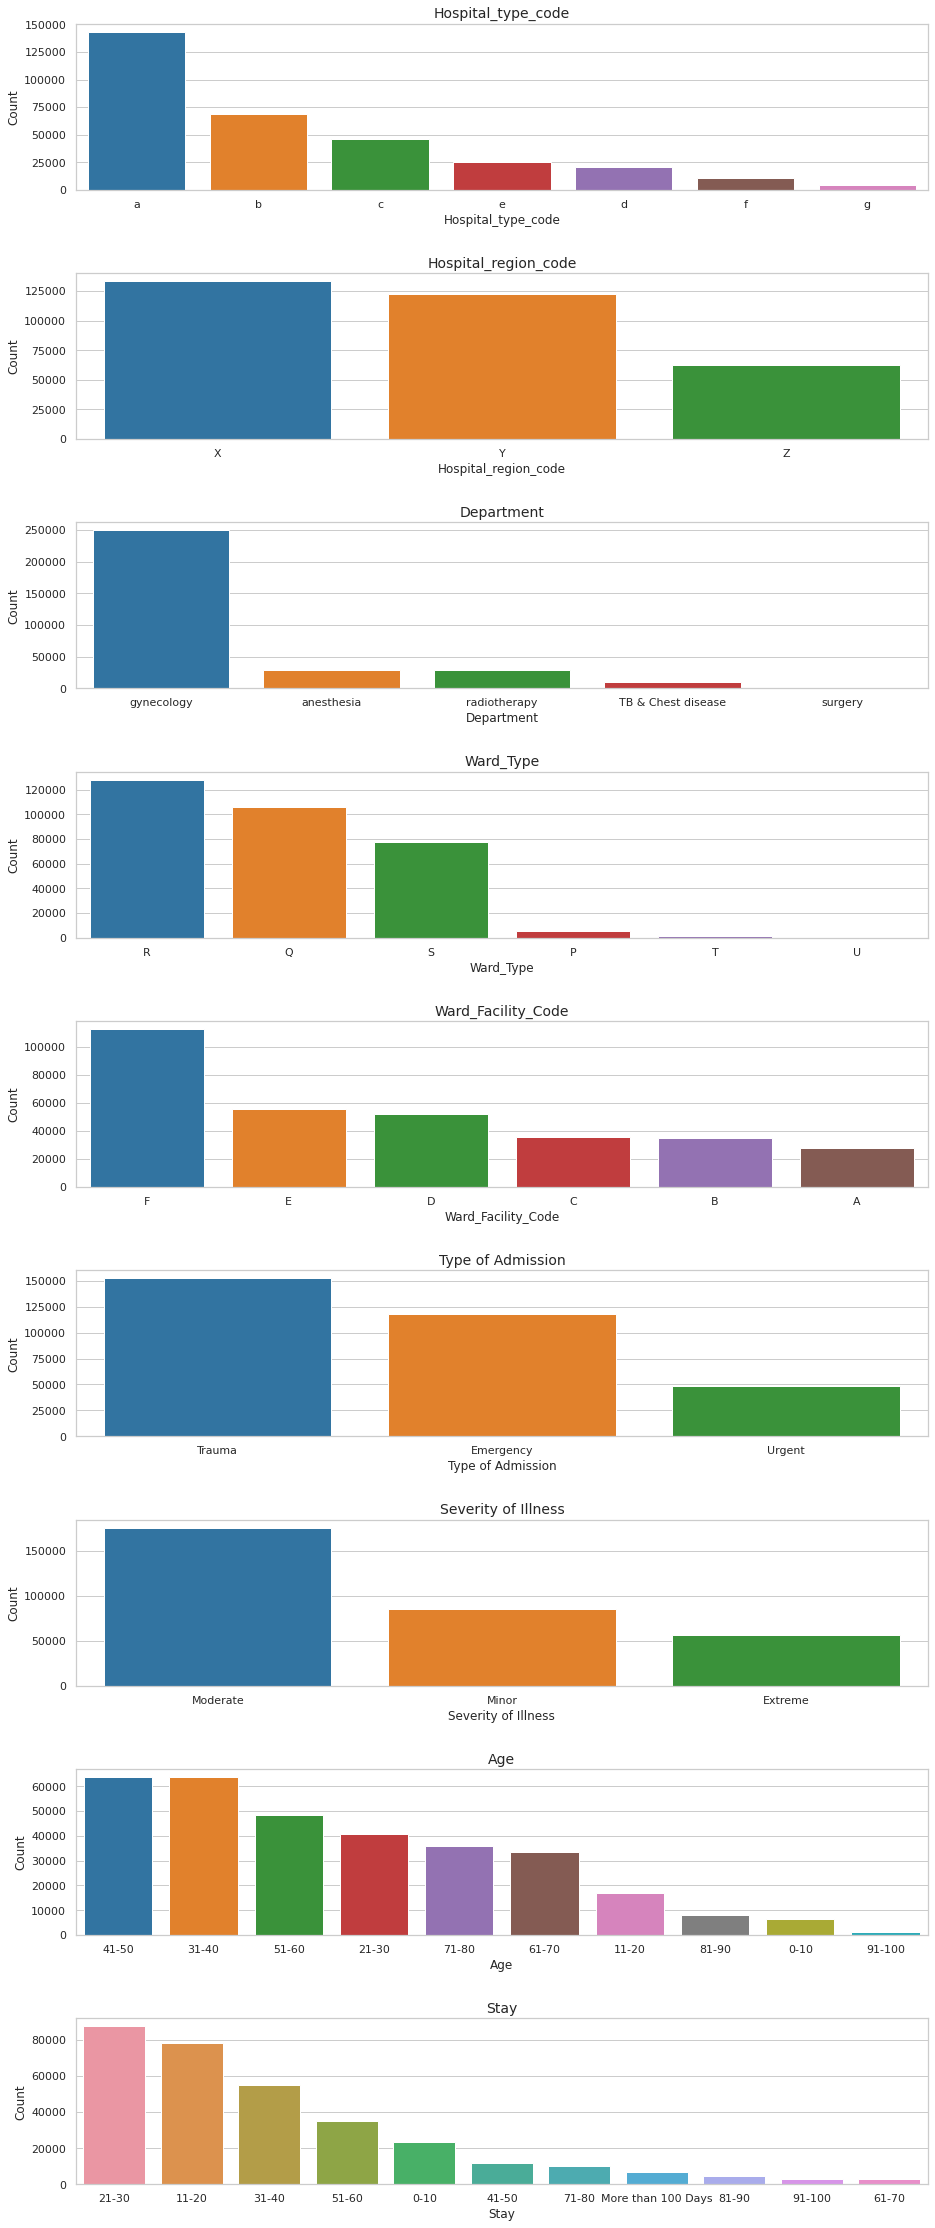

In [21]:
fig, ax = plt.subplots(len(cat_cols),1, figsize = (14, 32))
fig.tight_layout(pad = 5.0)

for ax, category in zip(ax.flatten(), cat_cols):
    x_axis = train[category].fillna('NaN').value_counts().index
    y_axis = train[category].fillna('NaN').value_counts()
    sns.barplot(ax = ax, x = x_axis, y = y_axis, order =  x_axis)
    ax.set_title(category, fontsize = 14)
    ax.set_xlabel(category)
    ax.set_ylabel('Count')
    
plt.show()

---

### Data preprocessing

#### Encoding categorical data

In [22]:
for col in cat_cols:
    print(col, sorted(train_data[col].unique()), len(sorted(train_data[col].unique())), "\n")

Hospital_type_code ['a', 'b', 'c', 'd', 'e', 'f', 'g'] 7 

Hospital_region_code ['X', 'Y', 'Z'] 3 

Department ['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy', 'surgery'] 5 

Ward_Type ['P', 'Q', 'R', 'S', 'T', 'U'] 6 

Ward_Facility_Code ['A', 'B', 'C', 'D', 'E', 'F'] 6 

Type of Admission ['Emergency', 'Trauma', 'Urgent'] 3 

Severity of Illness ['Extreme', 'Minor', 'Moderate'] 3 

Age ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'] 10 

Stay ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', 'More than 100 Days'] 11 



`Type of admission`, `severity of illness`, `age`, `stay`, `Hospital type code` and `ward type` can be label encoded since there is an ordinality. All the others must be one hot encoded.

* **Label Encoding ordinal catgorical data**

In [23]:
enc_tra_data = train_data.copy(deep=True)
enc_tes_data = test_data.copy(deep=True)

print(enc_tra_data.shape)

(313793, 12)


In [24]:
def labelEncode(enc_data, data, test=False):
    label_encoder = preprocessing.LabelEncoder()

    enc_data['Type of Admission'] = label_encoder.fit_transform(data['Type of Admission'])
    enc_data['Severity of Illness'] = label_encoder.fit_transform(data['Severity of Illness'])
    enc_data['Age'] = label_encoder.fit_transform(data['Age'])
    enc_data['Ward_Type'] = label_encoder.fit_transform(data['Ward_Type'])
    enc_data['Hospital_type_code'] = label_encoder.fit_transform(data['Hospital_type_code'])
    if not test:
        enc_data['Stay'] = label_encoder.fit_transform(data['Stay'])
    
    return enc_data

In [25]:
# LabelEncoding
enc_tra_data = labelEncode(enc_tra_data, train_data)
enc_tes_data = labelEncode(enc_tes_data, test_data, test=True)

print(enc_tra_data.shape)

enc_tra_data.head()

(313793, 12)


,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,Type of Admission,Severity of Illness,Age,Admission_Deposit,Stay
0,2,Z,3,radiotherapy,2,F,2.00,0,0,5,4911.00,0
1,2,Z,2,radiotherapy,3,F,2.00,1,0,5,5954.00,4
2,4,X,2,anesthesia,3,E,2.00,1,0,5,4745.00,3
3,1,Y,2,radiotherapy,2,D,2.00,1,0,5,7272.00,4
4,1,Y,2,radiotherapy,3,D,2.00,1,0,5,5558.00,4


* **One hot Encoding nominal categorical data**

In [26]:
def oneHotEncode(enc_data, data, cat_cols):
    for label in cat_cols[:5]:
        one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, drop = 'first', categories = 'auto')
        one_hot_encoder.fit(data[cat_cols[:5]])
        one_hot_df = one_hot_encoder.transform(data[cat_cols[:5]])
    
        for i in range(one_hot_df.shape[1]):
            enc_data[label + '_' + str(i)] = one_hot_df[:,i]
            
    # Drop unnecessary columns
    enc_data.drop(['Hospital_region_code', 'Department', 'Ward_Facility_Code']
           , axis = 1, inplace = True)
            
    return enc_data

In [27]:
# OneHotEncoding
cat_cols = ['Hospital_region_code', 'Department', 'Ward_Facility_Code']
enc_tra_data = oneHotEncode(enc_tra_data, train_data, cat_cols)
enc_tes_data = oneHotEncode(enc_tes_data, test_data, cat_cols)

print(enc_tra_data.shape)

enc_tra_data.head()

(313793, 42)


,Hospital_type_code,Available Extra Rooms in Hospital,Ward_Type,Bed Grade,Type of Admission,Severity of Illness,Age,Admission_Deposit,Stay,Hospital_region_code_0,...,Ward_Facility_Code_1,Ward_Facility_Code_2,Ward_Facility_Code_3,Ward_Facility_Code_4,Ward_Facility_Code_5,Ward_Facility_Code_6,Ward_Facility_Code_7,Ward_Facility_Code_8,Ward_Facility_Code_9,Ward_Facility_Code_10
0,2,3,2,2.00,0,0,5,4911.00,0,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
1,2,2,3,2.00,1,0,5,5954.00,4,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2,4,2,3,2.00,1,0,5,4745.00,3,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1,2,2,2.00,1,0,5,7272.00,4,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,1,2,3,2.00,1,0,5,5558.00,4,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [28]:
enc_tra_data.shape

(313793, 42)

#### Standarizing numerical data

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
def standarize(data, st_num_cols):
    sc = StandardScaler()

    sc.fit(data[st_num_cols])
    data[st_num_cols] = sc.transform(data[st_num_cols])
    
    return data

In [31]:
# not all need to be, only avalible_extra_rooms, bed_grade, visitors_with_patient, admission_deposit
st_num_cols = ['Available Extra Rooms in Hospital', 'Bed Grade', 'Admission_Deposit', 'Hospital_type_code', 'Ward_Type']

In [32]:
enc_tra_data = standarize(enc_tra_data, st_num_cols)
enc_tes_data = standarize(enc_tes_data, st_num_cols)

In [33]:
enc_tra_data.shape

(313793, 42)

In [34]:
enc_tra_data[st_num_cols]

,Available Extra Rooms in Hospital,Bed Grade,Admission_Deposit,Hospital_type_code,Ward_Type
0,-0.17,-0.71,0.03,0.48,0.14
1,-1.02,-0.71,0.99,0.48,1.38
2,-1.02,-0.71,-0.13,1.79,1.38
3,-1.02,-0.71,2.20,-0.17,0.14
4,-1.02,-0.71,0.62,-0.17,1.38
...,...,...,...,...,...
318433,-0.17,1.58,-0.68,-0.82,-1.11
318434,-1.02,1.58,1.67,-0.82,-1.11
318435,-0.17,1.58,-0.60,-0.82,0.14
318436,-0.17,0.43,-1.03,-0.17,-1.11


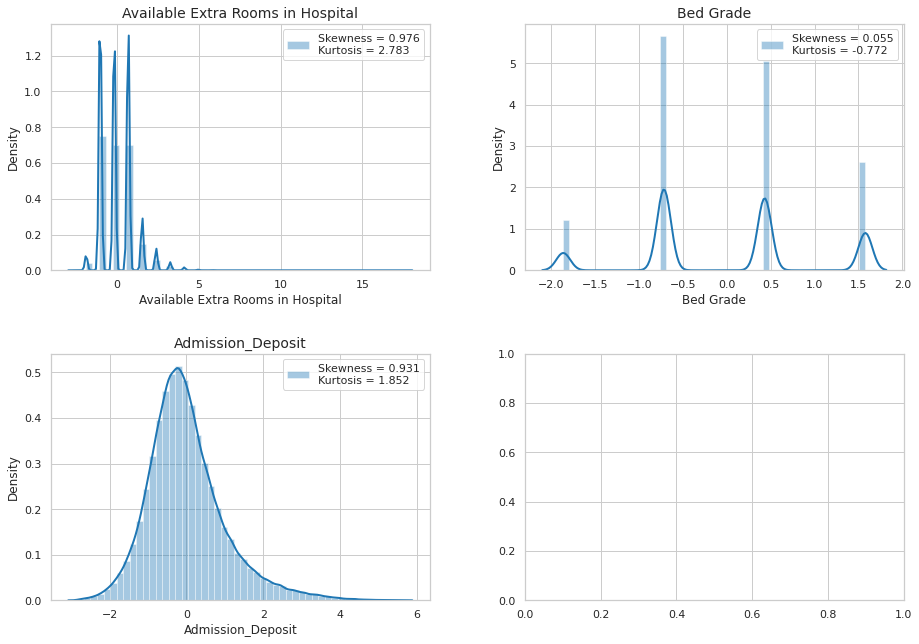

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))
fig.tight_layout(pad=5.0)

for ax, category in zip(ax.flatten(), num_cols):
    skew = enc_tra_data[category].skew()
    kurt = enc_tra_data[category].kurt()
    lab = "Skewness = {:.3f}\nKurtosis = {:.3f}".format(skew, kurt)
    sns.distplot(ax=ax, a=enc_tra_data[category].dropna(), label=lab)
    ax.set_title(category, fontsize = 14)
    ax.legend(loc = 'best')

* **Applying select best k**

In [36]:
X = enc_tra_data.loc[:, enc_tra_data.columns != 'Stay']
y = enc_tra_data['Stay']

print(X.shape, y.shape)

X_test = enc_tes_data
y_test = np.zeros(X_test.shape[0])

(313793, 41) (313793,)


In [37]:
# Or we could create a function to get X,y (preprocessed thorugh the process above) from a given dataset
def get_X_y(data, cat_cols, num_cols, st_num_cols):
    data = data.dropna()
    data.drop(['case_id', 'patientid', 'Hospital_code', 'City_Code_Hospital', 'City_Code_Patient']
               , axis = 1, inplace = True)
    enc_data = data.copy(deep=True)
    enc_data = labelEncode(enc_data, data)
    enc_data = oneHotEncode(enc_data, data, cat_cols)
    enc_data = standarize(enc_data, st_num_cols)
    
    return enc_data.loc[:, enc_data.columns != 'Stay'], enc_data['Stay']

In [38]:
X, y = get_X_y(train, cat_cols, num_cols, st_num_cols)
print(X.shape, y.shape)

(313793, 42) (313793,)


We have a lot of categories, we can use sklearn's feature selection library to select the $K$ best number of features:

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif

In [40]:
def select_K_best(X_data, y_data, k):
    # Create and fit selector
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_data, y_data)
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    data_aux = X_data.iloc[:,cols]
    
    return data_aux

In [41]:
X_best_k = select_K_best(X, y, 10)
X_test_best_k = select_K_best(X_test, y_test, 10)

In [42]:
X_best_k

,Available Extra Rooms in Hospital,Ward_Type,Bed Grade,Type of Admission,Visitors with Patient,Age,Admission_Deposit,Hospital_region_code_7,Department_7,Ward_Facility_Code_7
0,-0.17,0.14,-0.71,0,2,5,0.03,0.00,0.00,0.00
1,-1.02,1.38,-0.71,1,2,5,0.99,0.00,0.00,0.00
2,-1.02,1.38,-0.71,1,2,5,-0.13,0.00,0.00,0.00
3,-1.02,0.14,-0.71,1,2,5,2.20,0.00,0.00,0.00
4,-1.02,1.38,-0.71,1,2,5,0.62,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
318433,-0.17,-1.11,1.58,0,3,4,-0.68,0.00,0.00,0.00
318434,-1.02,-1.11,1.58,2,4,8,1.67,0.00,0.00,0.00
318435,-0.17,0.14,1.58,0,3,7,-0.60,0.00,0.00,0.00
318436,-0.17,-1.11,0.43,1,5,1,-1.03,0.00,0.00,0.00


---

## Models

### Linear regression

We don't want to use all 118 attributes of the dataset. We will simply select the best $K$ variables to use for each regressor. However, if we tried with all possible values of $K$ (i.e. from 1 to 118), it would be too much time consuming, so we will just set $K = 20$.

In [43]:
# Best 10 features
X_best_k.columns

Index(['Available Extra Rooms in Hospital', 'Ward_Type', 'Bed Grade',
       'Type of Admission', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Hospital_region_code_7', 'Department_7',
       'Ward_Facility_Code_7'],
      dtype='object')

* **Linear regressor:**

In [44]:
X_best_k.shape

(313793, 10)

In [45]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_best_k, y)

regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train) 
print ('\nCoefs (per dim) ', regressor.coef_, ' and intercept: ', regressor.intercept_)
# Best possible score is 1.0, lower values (even negatives!!) are worse.
print ('\nTraining Score:', regressor.score(X_train, y_train) )
print ('Testing Score:', regressor.score(X_val, y_val) )
print ('\nTraining MSE: ', mse(regressor.predict(X_train), y_train))
print ('Testing MSE: ', mse(regressor.predict(X_val), y_val))


Coefs (per dim)  [-0.18821489  0.4260357  -0.1156212   0.2124354   0.70419865  0.04765225
  0.01492479 -0.16447966 -0.16447966 -0.16447966]  and intercept:  0.07900048403671933

Training Score: 0.3661952017553812
Testing Score: 0.3676933209066283

Training MSE:  2.9227420189175644
Testing MSE:  2.9212299930919894


* **Lasso regression:**

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_best_k, y, )

# Create a Lasso regressor
regressor_lasso = linear_model.LassoCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
regressor_lasso.fit(X_train, y_train) 
print('Alpha: ', regressor_lasso.alpha_)
print ('Coeffs (per dim): ', regressor_lasso.coef_, 'and intercept:', regressor_lasso.intercept_)

print ('\nTraining Score:', regressor_lasso.score(X_train, y_train)) 
print ('Testing Score:', regressor_lasso.score(X_val, y_val)) 
print ('\nTraining MSE: ', mse(regressor_lasso.predict(X_train), y_train))
print ('Testing MSE: ', mse(regressor_lasso.predict(X_val), y_val))

Alpha:  0.0001
Coeffs (per dim):  [-1.86053671e-01  4.34291751e-01 -1.19443052e-01  2.16510013e-01
  7.04412477e-01  4.67436986e-02  1.61387211e-02 -5.11252306e-01
 -1.46735706e-15 -2.01755907e-17] and intercept: 0.07937523342844477

Training Score: 0.36775215283128393
Testing Score: 0.3630341029977835

Training MSE:  2.9196710412289435
Testing MSE:  2.930347670222417


* **Ridge regressor:**

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_best_k, y)

# Create a Ridge regressor
regressor_ridge = linear_model.RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
regressor_ridge.fit(X_train, y_train)
print('Alpha: ', regressor_ridge.alpha_)
print ('Coeffs (per dim): ', regressor_ridge.coef_, 'and intercept:', regressor_ridge.intercept_)
#print (feature_names)
# Are the coeficients now sparse?
print ('\nTraining Score:', regressor_ridge.score(X_train, y_train)) 
print ('Testing Score:', regressor_ridge.score(X_val, y_val)) 
print ('\nTraining MSE: ', mse(regressor_ridge.predict(X_train), y_train))
print ('Testing MSE: ', mse(regressor_ridge.predict(X_val), y_val))

Alpha:  10.0
Coeffs (per dim):  [-0.1887334   0.43069678 -0.11240933  0.213519    0.70550561  0.04814477
  0.01654223 -0.16912599 -0.16912599 -0.16912599] and intercept: 0.06983857961355033

Training Score: 0.368721649748888
Testing Score: 0.36004084490259525

Training MSE:  2.9230094767852153
Testing MSE:  2.9203501134652594


* **Visualization:**

In [49]:
def model_visualization(model, X, y, title, save_plot=False):
    X_train, X_val, y_train, y_val = train_test_split(X_best_k, y, train_size=0.8, test_size=0.2)
    
    model.fit(X_train, y_train)
    f,  (ax1, ax2)  =  plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    train_predicted = np.round_(model.predict(X_train))
    predicted = np.round_(model.predict(X_val))
    
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_val, y_val)
    training_acc = accuracy_score(y_train, train_predicted)
    validation_acc = accuracy_score(y_val, predicted)
    
    textstr = AnchoredText("Training score={:.5f}\nTest score = {:.5f}\nTrain acc = {:.5f}\nTest acc = {:.5f}".format(training_score
                           , test_score, training_acc, validation_acc)
                           , loc=2)
    
    ax1.scatter(y_val, predicted, alpha = 0.3)
    ax1.plot([y_val.min(), y_val.max()], [predicted.min(), predicted.max()], '--k')
    ax1.set_xlabel('True count')
    ax1.set_ylabel('Predicted count')
    ax1.add_artist(textstr)

    ax2.scatter(range(len(predicted)), y_val, alpha = 0.3, color='y')
    ax2.scatter(range(len(predicted)), predicted, alpha = 0.3, color='m')
    ax2.set_xlabel('True count')
    ax2.set_ylabel('Predicted count')
    ax2.legend(['True value', 'Predicted value'])
    
    if save_plot:
        plt.savefig('Imatges/{}.png'.format(title), dpi=300, bbox_inches='tight')
    
    print(str(model))
    print("Training score: ", training_score)  # Best possible score is 1.0, lower values are worse.
    print("Test score: ", test_score)

LinearRegression()
Training score:  0.36722542317538864
Test score:  0.3639389949196644


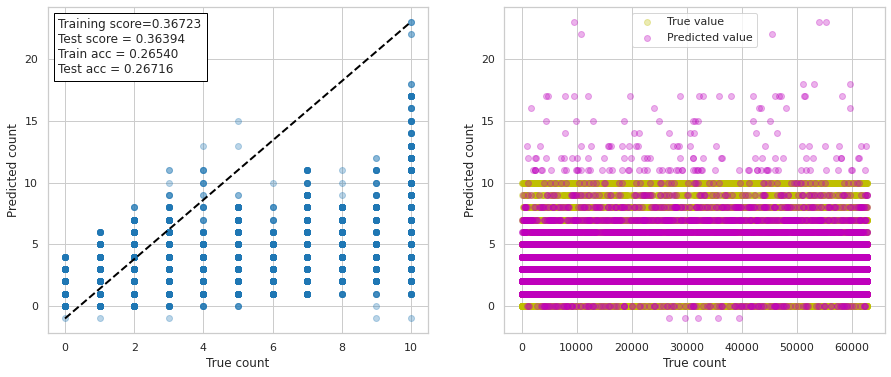

In [50]:
model_visualization(LinearRegression(), X, y, 'Linear_regression_all_features')

Lasso(alpha=0.0001)
Training score:  0.3654301428259139
Test score:  0.37109539644580825


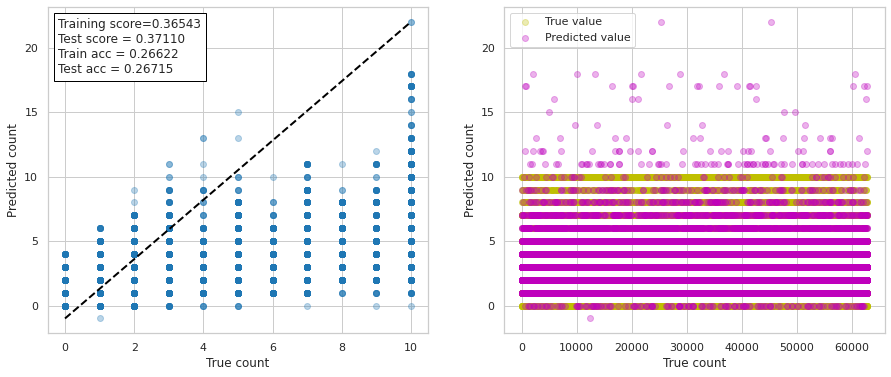

In [51]:
model_visualization(Lasso(alpha=0.0001), X, y, 'Linear_regression_all_features')

Ridge(alpha=0.0001)
Training score:  0.36762457975113494
Test score:  0.36235232433510445


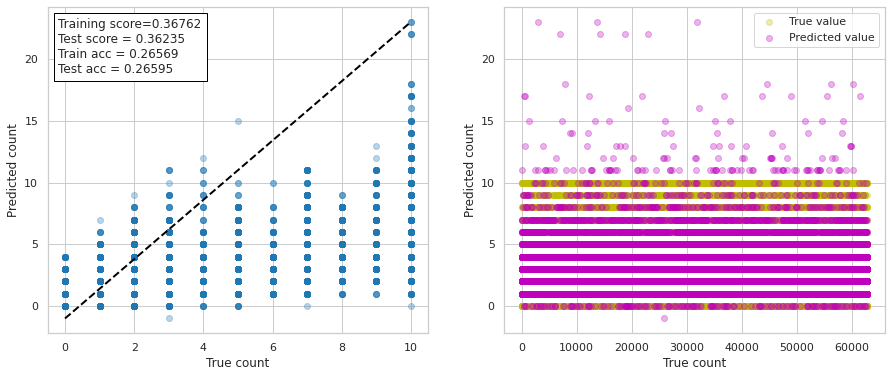

In [52]:
model_visualization(Ridge(alpha=0.0001), X, y, 'Linear_regression_all_features')

Since we have a problem of multi-class classification, linear regression does not work well (as expected) so we will look into other more powerful and suitable techniques for this type of problems.

### Multi-class classification
* **K-nearest neighbours classification**

The K-nearest neighbours (KNN) is a simple method that can work very well. 

In [53]:
def visualize_confusion_matrix(y_pred, y_real):
    #mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
def visualize_knn_accuracy(acc_arr, avg):
    cols = ['blue', 'cyan', 'green', 'yellow', 'purple', 'magenta', 'orange']
    n = len(acc_arr)
    for i in range(n):
        x_ax = []
        y_ax = []
        for a in acc_arr[i]:
            x_ax.append(a[0])
            y_ax.append(a[1])
        plt.plot(x_ax, y_ax, color=cols[i], label="iteration {}".format(i))
    plt.plot(x_ax, avg, '--', color='red', label="Average")
    plt.legend(loc="lower right")
    plt.show()

In [54]:
def try_ks_knn(X_knn, y_knn, quick=False, pctg=0.6, alg='auto', verbose=False, k_vals=[5]):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_knn.shape[0] * pctg))
        indices = [randint(0, X_knn.shape[0]-1) for _ in range(size)]
        X_knn = X_knn.iloc[indices]
        y_knn = y_knn.iloc[indices]
    accs = []
    for k in k_vals:
        if verbose:
            print("K = {}".format(k))
        X_train, X_val, y_train, y_val = train_test_split(X_knn, y_knn, train_size=0.8, test_size=0.2)
        knn_classifier = KNeighborsClassifier(n_neighbors=k, algorithm=alg)
        if verbose:
            print("Fitting...")
        knn_classifier.fit(X_train, y_train)
        if verbose:
            print("Predicting...")
        knn_preds = knn_classifier.predict(X_val)
        accs.append([k,accuracy_score(y_val, knn_preds)])
        if verbose:
            print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return accs, knn_preds

In [55]:
# Fem l'experiment n vegades per veure quin nombre k de veins és el més adequat (fem servir 
# l'algoritme auto que ens selecciona el que creu que funcionarà millor)
n = 5
axes = []
accs_knn = []
preds = []
ks = np.arange(5,51,5)
for i in range(n):
    acc, y_pred = try_ks_knn(X_best_k, y, quick=True, pctg=0.2, alg='auto', k_vals=ks)
    accs_knn.append(acc)
    preds.append(y_pred)

EXPERIMENT FINISHED
EXPERIMENT FINISHED
EXPERIMENT FINISHED
EXPERIMENT FINISHED
EXPERIMENT FINISHED


In [56]:
avg_knn_accs = []
for i in range(len(ks)):
    avg_knn_accs.append(sum(a[i][1] for a in accs_knn)/n)

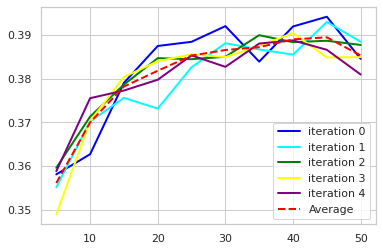

In [57]:
visualize_knn_accuracy(accs_knn, avg_knn_accs)

We see a general upwards trend for the accuracy as the value of k increases, where generally a value of k between 25 and 50 yields the higher accuracies. The KNN calssifier however is not giving us very good results, since the accuracy hardly surpases a value of 40%.

In [58]:
def experiment_knn(X_knn, y_knn, quick=False, pctg=0.6, verbose=False, alg='auto', k=5):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_knn.shape[0] * pctg))
        indices = [randint(0, X_knn.shape[0]-1) for _ in range(size)]
        X_knn = X_knn.iloc[indices]
        y_knn = y_knn.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X_knn, y_knn, train_size=0.8, test_size=0.2)
    knn_classifier = KNeighborsClassifier(n_neighbors=k, algorithm=alg)
    if verbose:
        print("Fitting...")
    knn_classifier.fit(X_train, y_train)
    if verbose:
        print("Predicting...")
    knn_preds = knn_classifier.predict(X_val)
    acc = accuracy_score(y_val, knn_preds)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [59]:
acc_knn = experiment_knn(X_best_k, y, quick=True, verbose=True, pctg=0.5, k=35)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [60]:
acc_knn

0.39216061185468454

* **Random forest classifier**

Let's now look into the Random forest classifiers, where we use multiple decision trees to generate a reliable classifier.

In [61]:
def experiment_rf(X_rf, y_rf, quick=False, pctg=0.6, verbose=False, n_est=100, criterion='gini', max_depth=None):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_rf.shape[0] * pctg))
        indices = [randint(0, X_rf.shape[0]-1) for _ in range(size)]
        X_rf = X_rf.iloc[indices]
        y_rf = y_rf.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X_rf, y_rf, train_size=0.8, test_size=0.2)
    rf_classifier = RandomForestClassifier(n_estimators=n_est, criterion=criterion, max_depth=max_depth)
    if verbose:
        print("Fitting...")
    rf_classifier.fit(X_train, y_train)
    if verbose:
        print("Predicting...")
    rf_preds = rf_classifier.predict(X_val)
    acc = accuracy_score(y_val, rf_preds)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [62]:
acc_rf = experiment_rf(X_best_k, y, quick=True, verbose=True, pctg=0.5, n_est=20)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [63]:
acc_rf

0.5317080943275972

* **Decision tree classifier**

In [64]:
def experiment_dt(X_dt, y_dt, quick=False, pctg=0.6, verbose=False, splitter='best', criterion='gini', max_depth=None):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_dt.shape[0] * pctg))
        indices = [randint(0, X_dt.shape[0]-1) for _ in range(size)]
        X_dt = X_dt.iloc[indices]
        y_dt = y_dt.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X_dt, y_dt, train_size=0.8, test_size=0.2)
    dt_classifier = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
    if verbose:
        print("Fitting...")
    dt_classifier.fit(X_train, y_train)
    if verbose:
        print("Predicting...")
    dt_preds = dt_classifier.predict(X_val)
    acc = accuracy_score(y_val, dt_preds)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [65]:
acc_dt = experiment_dt(X_best_k, y, quick=True, verbose=True, pctg=0.5)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [66]:
acc_dt

0.5103250478011472

* **Cat Boost classifier**

In [67]:
def experiment_cb(X_cb, y_cb, quick=False, pctg=0.6, verbose=False):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_cb.shape[0] * pctg))
        indices = [randint(0, X_cb.shape[0]-1) for _ in range(size)]
        X_cb = X_cb.iloc[indices]
        y_cb = y_cb.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X_cb, y_cb, train_size=0.8, test_size=0.2)
    cb_classifier = CatBoostClassifier(verbose=False)
    if verbose:
        print("Fitting...")
    cb_classifier.fit(X_train, y_train)
    if verbose:
        print("Predicting...")
    cb_preds = cb_classifier.predict(X_val)
    acc = accuracy_score(y_val, cb_preds)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [68]:
acc_cb = experiment_cb(X_best_k, y, quick=True, verbose=True, pctg=0.5)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [69]:
acc_cb

0.41532823454429574

* **XGB classifier**

In [70]:
def experiment_xgb(X_xgb, y_xgb, quick=False, pctg=0.6, verbose=False):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_xgb.shape[0] * pctg))
        indices = [randint(0, X_xgb.shape[0]-1) for _ in range(size)]
        X_xgb = X_xgb.iloc[indices]
        y_xgb = y_xgb.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X_xgb, y_xgb, train_size=0.8, test_size=0.2)
    xgb_classifier = XGBClassifier()
    if verbose:
        print("Fitting...")
    xgb_classifier.fit(X_train, y_train)
    if verbose:
        print("Predicting...")
    xgb_preds = xgb_classifier.predict(X_val)
    acc = accuracy_score(y_val, xgb_preds)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [71]:
acc_xgb = experiment_xgb(X_best_k, y, quick=True, verbose=True, pctg=0.5)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [72]:
acc_xgb

0.4221478648820905

* **Light GBM classifier**

In [73]:
def experiment_lgbm(X_lgbm, y_lgbm, quick=False, pctg=0.6, verbose=False):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X_lgbm.shape[0] * pctg))
        indices = [randint(0, X_lgbm.shape[0]-1) for _ in range(size)]
        X_lgbm = X_lgbm.iloc[indices]
        y_lgbm = y_lgbm.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X_lgbm, y_lgbm, train_size=0.8, test_size=0.2)
    lgbm_classifier = lgb.LGBMClassifier()
    if verbose:
        print("Fitting...")
    lgbm_classifier.fit(X_train, y_train)
    if verbose:
        print("Predicting...")
    lgbm_preds = lgbm_classifier.predict(X_val)
    acc = accuracy_score(y_val, lgbm_preds)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [74]:
acc_lgbm = experiment_lgbm(X_best_k, y, quick=True, verbose=True, pctg=0.5)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [75]:
acc_lgbm

0.4098151688973869

In [76]:
classifiers = [
    KNeighborsClassifier(n_neighbors=35, algorithm='auto'),
    DecisionTreeClassifier(splitter='best', criterion='gini', max_depth=None),
    RandomForestClassifier(n_estimators=20),
    CatBoostClassifier(verbose=False),
    XGBClassifier(),
    lgb.LGBMClassifier(),
    OneVsRestClassifier(RandomForestClassifier(n_estimators=20)),
    OneVsOneClassifier(DecisionTreeClassifier(splitter='best', criterion='gini', max_depth=None))
]

names = [
    "K Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Cat boost",
    "XGB",
    "LGBM",
    "One-vs-Rest with Random forest",
    "One-vs-One with Decision tree"
]

In [77]:
def model_compare(X, y, models, names, times=10, pctg=0.5, all_results=True, verbose=False, quick=False):
    training_score = dict.fromkeys(names, 0)
    validation_score = dict.fromkeys(names, 0)
    f1score = dict.fromkeys(names, 0)
    exec_time = dict.fromkeys(names, 0)
    
    if quick:
        size = int(np.ceil(X.shape[0] * pctg))
        indices = [randint(0, X.shape[0]-1) for _ in range(size)]
        X = X.iloc[indices]
        y = y.iloc[indices]

    for i in range(times):
        if verbose:
            print("Iteration {}".format(i))
        X_train, X_val, y_train, y_val = train_test_split(X, y)
        for model, title in zip(models, names):
            if verbose:
                print("    -> Running model {}".format(title))
            
            start_time = time.time()
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            training_score[title] += model.score(X_train, y_train)
            validation_score[title] += model.score(X_val, y_val)
            f1score[title] += f1_score(y_preds, y_val, average='micro')
            end_time = time.time()
            exec_time[title] += end_time - start_time
            
        if verbose:
            print("-----------------------------------------------")

    training_score = {k: v / times for k, v in training_score.items()}
    validation_score = {k: v / times for k, v in validation_score.items()}
    f1score = {k: v / times for k, v in f1score.items()}
    exec_time = {k: v / times for k, v in exec_time.items()}
    
    best_model = max(validation_score, key=validation_score.get)
    
    print('\nBest model: ', best_model)
    print('Training score: ', training_score[best_model])
    print('Validation score: ', validation_score[best_model])
    print('f1score: ', f1score[best_model])
    print('Execution time', exec_time[best_model])
    
    data = {'Model':[], 'Training score':[], 'Validation score':[], 'f1 score':[], 'Execution time (s)':[]}
    if all_results:
        for title in names:
            data['Model'].append(title)
            data['Training score'].append(training_score[title])
            data['Validation score'].append(validation_score[title])
            data['f1 score'].append(f1score[title])
            data['Execution time (s)'].append(exec_time[title])
        df = pd.DataFrame(data)
        print(tabulate(df, headers = 'keys', tablefmt = 'psql', showindex=False))

In [78]:
model_compare(X_best_k, y, classifiers, names, times=1, pctg=0.4, verbose=True, quick=True)

Iteration 0
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One with Decision tree
-----------------------------------------------

Best model:  One-vs-Rest with Random forest
Training score:  0.9921179544923411
Validation score:  0.4865838113448056
f1score:  0.4865838113448056
Execution time 25.6771559715271
+--------------------------------+------------------+--------------------+------------+----------------------+
| Model                          |   Training score |   Validation score |   f1 score |   Execution time (s) |
|--------------------------------+------------------+--------------------+------------+----------------------|
| K Nearest Neighbors            |         0.431037 |           0.390153 |   0.390153 |            34.873    |
| Decision Tree     

### Balancing data

As seen in the EDA section, the `Stay` variable is not balanced. In this section we will use both over-sampling and under-sampling techniques to try to improve our results.

* **Over-sampling with SMOTE**

In [79]:
sm = SMOTE()
# For time complexity purposes, we will trim our dataset to less than 100k samples
size = int(np.ceil(X.shape[0] * 0.3))
indices = [randint(0, X.shape[0]-1) for _ in range(size)]
os_X, os_y = sm.fit_resample(X.iloc[indices], y.iloc[indices])
os_X_best_k, _ = sm.fit_resample(X_best_k.iloc[indices], y.iloc[indices])

Let's check if the data is balanced:

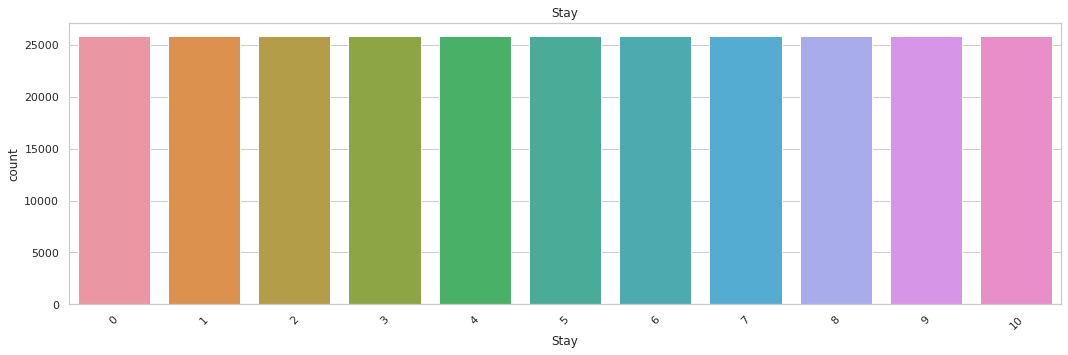

In [80]:
figure(figsize=(15,5))
sns.countplot('Stay', data=pd.concat([os_X, os_y], axis=1))
plt.title('Stay')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [81]:
model_compare(os_X_best_k, os_y, classifiers, names, times=3, pctg=0.4, verbose=True, quick=True)

Iteration 0
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One with Decision tree
-----------------------------------------------
Iteration 1
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One with Decision tree
-----------------------------------------------
Iteration 2
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One

In [82]:
model_compare(os_X, os_y, classifiers, names, times=1, pctg=0.4, verbose=True, quick=True)

Iteration 0
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One with Decision tree
-----------------------------------------------

Best model:  Random Forest
Training score:  0.9985811111892868
Validation score:  0.7581876385126816
f1score:  0.7581876385126816
Execution time 3.9920566082000732
+--------------------------------+------------------+--------------------+------------+----------------------+
| Model                          |   Training score |   Validation score |   f1 score |   Execution time (s) |
|--------------------------------+------------------+--------------------+------------+----------------------|
| K Nearest Neighbors            |         0.538275 |           0.501882 |   0.501882 |            314.535   |
| Decision Tree                  | 

* **Under-sampling randomly**

In [83]:
rus = RandomUnderSampler(random_state=42)
rus_X, rus_y = rus.fit_resample(X, y)
rus_X_best_k, _ = rus.fit_resample(X_best_k, y)

Again, we check if the data is balanced:

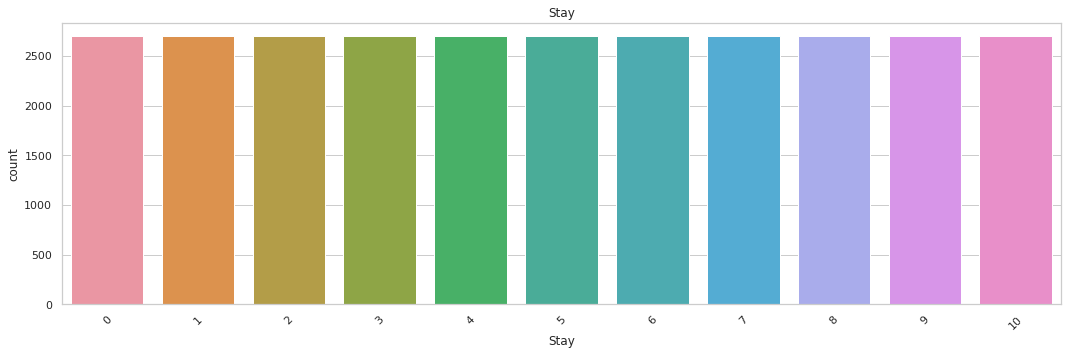

In [84]:
figure(figsize=(15,5))
sns.countplot('Stay', data=pd.concat([rus_X, rus_y], axis=1))
plt.title('Stay')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [85]:
model_compare(rus_X_best_k, rus_y, classifiers, names, times=1, pctg=1.0, verbose=True, quick=True)

Iteration 0
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One with Decision tree
-----------------------------------------------

Best model:  One-vs-One with Decision tree
Training score:  0.999415940336059
Validation score:  0.6409703504043127
f1score:  0.6409703504043127
Execution time 1.4876031875610352
+--------------------------------+------------------+--------------------+------------+----------------------+
| Model                          |   Training score |   Validation score |   f1 score |   Execution time (s) |
|--------------------------------+------------------+--------------------+------------+----------------------|
| K Nearest Neighbors            |         0.343337 |           0.286792 |   0.286792 |             4.11955  |
| Decision Tree     

In [86]:
model_compare(rus_X, rus_y, classifiers, names, times=1, pctg=1.0, verbose=True, quick=True)

Iteration 0
    -> Running model K Nearest Neighbors
    -> Running model Decision Tree
    -> Running model Random Forest
    -> Running model Cat boost
    -> Running model XGB
    -> Running model LGBM
    -> Running model One-vs-Rest with Random forest
    -> Running model One-vs-One with Decision tree
-----------------------------------------------

Best model:  One-vs-Rest with Random forest
Training score:  0.999820289334172
Validation score:  0.6438005390835579
f1score:  0.6438005390835579
Execution time 4.76449179649353
+--------------------------------+------------------+--------------------+------------+----------------------+
| Model                          |   Training score |   Validation score |   f1 score |   Execution time (s) |
|--------------------------------+------------------+--------------------+------------+----------------------|
| K Nearest Neighbors            |         0.349043 |           0.286792 |   0.286792 |            25.5181   |
| Decision Tree      

We see that we get better results with the over-sampled data.

### Ensemble methods

* **One-vs-Rest**

In [87]:
def experiment_ovr(X, y, model=MLPClassifier(hidden_layer_sizes=20), pctg=0.5, quick=False, verbose=False):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X.shape[0] * pctg))
        indices = [randint(0, X.shape[0]-1) for _ in range(size)]
        X = X.iloc[indices]
        y = y.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2)
    dnns_clf = OneVsRestClassifier(model)
    if verbose:
        print("Fitting...")
    dnns_clf.fit(np.array(X_train), y_train)
    if verbose:
        print("Predicting...")
    dnns_pred = dnns_clf.predict(X_val)
    acc = accuracy_score(y_val, dnns_pred)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [88]:
acc_ovr = experiment_ovr(os_X_best_k, os_y, model=RandomForestClassifier(n_estimators=20), pctg=1, quick=True, verbose=True)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [89]:
acc_ovr

0.8421719170492322

In [90]:
acc_ovr = experiment_ovr(os_X_best_k, os_y, model=DecisionTreeClassifier(splitter='best', criterion='gini', max_depth=None), pctg=1.0, quick=True, verbose=True)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [91]:
acc_ovr

0.7932738817652543

* **One-vs-One**

In [92]:
def experiment_ovo(X, y, model=MLPClassifier(hidden_layer_sizes=20), pctg=0.5, quick=False, verbose=False):
    # We take portion of the data to make things quicker
    if quick:
        size = int(np.ceil(X.shape[0] * pctg))
        indices = [randint(0, X.shape[0]-1) for _ in range(size)]
        X = X.iloc[indices]
        y = y.iloc[indices]
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2)
    dnns_clf = OneVsOneClassifier(model)
    if verbose:
        print("Fitting...")
    dnns_clf.fit(np.array(X_train), y_train)
    if verbose:
        print("Predicting...")
    dnns_pred = dnns_clf.predict(X_val)
    acc = accuracy_score(y_val, dnns_pred)
    if verbose:
        print("----------------------------------------------")
    print("EXPERIMENT FINISHED")
    return acc

In [93]:
acc_ovo = experiment_ovo(os_X_best_k, os_y, model=RandomForestClassifier(n_estimators=50), pctg=0.6, quick=True, verbose=True)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [94]:
acc_ovo

0.7613449812382739

In [95]:
acc_ovo = experiment_ovo(os_X, os_y, model=DecisionTreeClassifier(splitter='best', criterion='gini', max_depth=None), pctg=1.0, quick=True, verbose=True)

Fitting...
Predicting...
----------------------------------------------
EXPERIMENT FINISHED


In [96]:
acc_ovo

0.8574393611594815

---

In [100]:
# Compute Precision-Recall and plot curve
def prc_curve_area(y_val, probs, n_classes, ax):
    precision = {}
    recall = {}
    average_precision = {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_val == i, probs[:, i])
        average_precision[i] = average_precision_score(y_val == i, probs[:, i])

        ax.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                            ''.format(i, average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc="lower right")

    
# Compute ROC curve and ROC area for each class
def roc_curve_area(y_val, probs, n_classes, name, ax):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    
    # Plot ROC curve
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
        
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, '--k', alpha=0.75, zorder=0)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc="lower right")

def prc_roc_curves_area(X, y, n_classes, classifier, name=None, save_plot=False):
    X_train, X_val, y_train, y_val = train_test_split(X, y)

    model = classifier.fit(X_train, y_train)
    probs = model.predict_proba(X_val)
    
    f,  (ax1, ax2)  =  plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    ax1.title.set_text("Precision-recall curve for {} classifier".format(name))
    ax2.title.set_text("ROC curve for {} classifier".format(name))
    
    print("Plotting PRC for model {}".format(name))
    prc_curve_area(y_val, probs, n_classes, ax=ax1)
    print("Plotting ROC for model {}".format(name))
    roc_curve_area(y_val, probs, n_classes, name, ax=ax2)
    print("")
    
    if save_plot:
        current_directory_path = os.getcwd()
        file_name = '{}.png'.format(name)
        subfolder_path = os.path.join(current_directory_path, 'images')
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
        file_path = os.path.join(subfolder_path, file_name)
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    
    f.tight_layout()

Plotting PRC for model K Nearest Neighbors
Plotting ROC for model K Nearest Neighbors

Plotting PRC for model Decision Tree
Plotting ROC for model Decision Tree

Plotting PRC for model Random Forest
Plotting ROC for model Random Forest

Plotting PRC for model Cat boost
Plotting ROC for model Cat boost

Plotting PRC for model XGB
Plotting ROC for model XGB

Plotting PRC for model LGBM
Plotting ROC for model LGBM

Plotting PRC for model One-vs-Rest with Random forest
Plotting ROC for model One-vs-Rest with Random forest



AttributeError: 'OneVsOneClassifier' object has no attribute 'predict_proba'

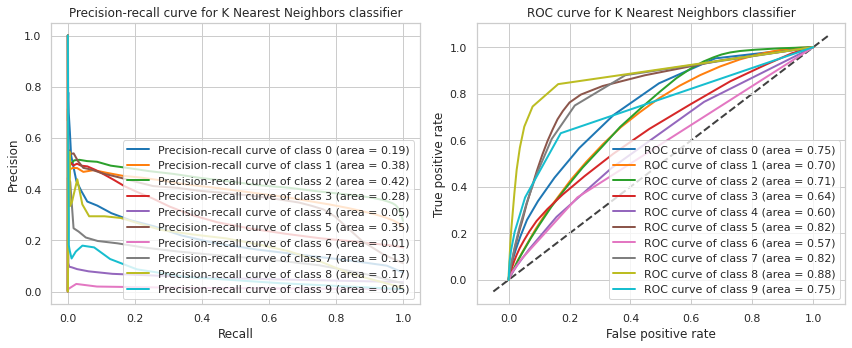

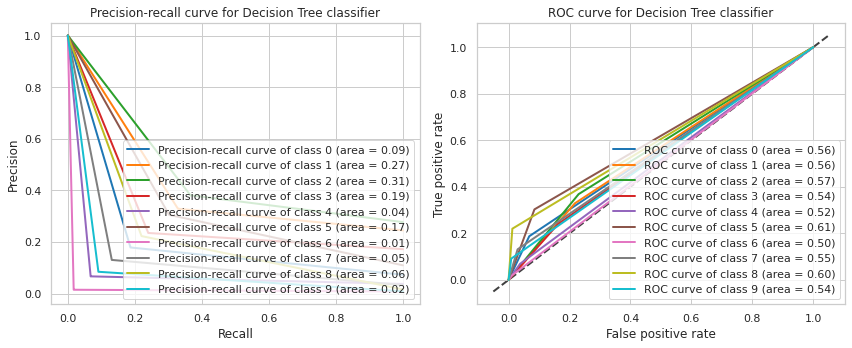

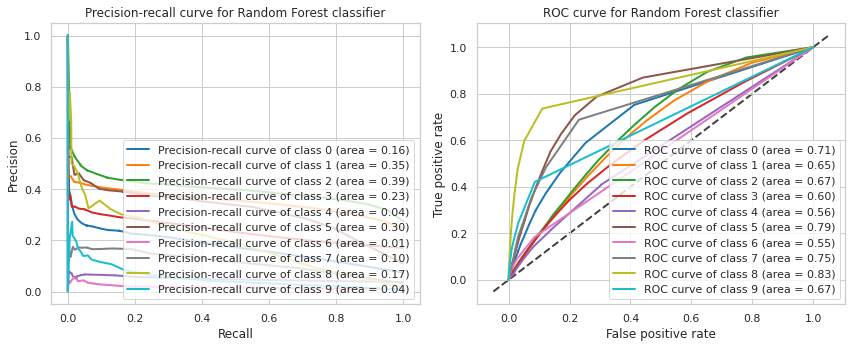

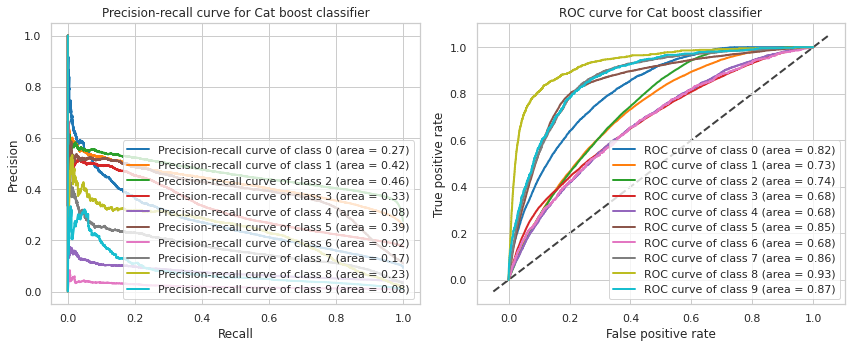

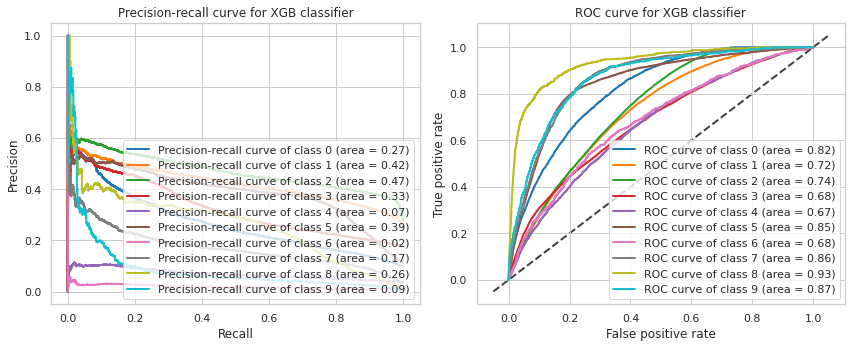

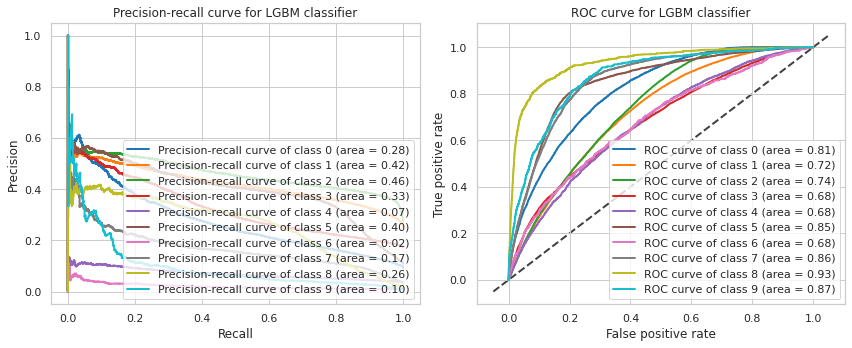

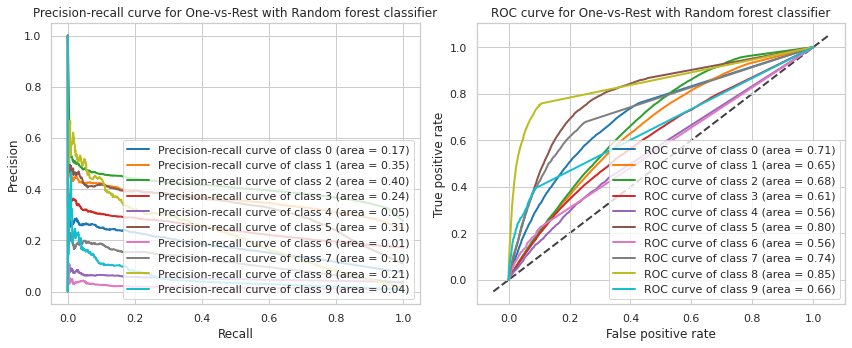

In [101]:
for model, title in zip(classifiers, names):
    prc_roc_curves_area(X, y, 10, model, name=title, save_plot=True)